# Import Libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
np.set_printoptions(precision=4, edgeitems=10, linewidth=100000)

import matplotlib
from matplotlib.patches import Ellipse

# Divergences

In [10]:
# Definitions to compute the Hellinger Divergence and total variation distance

def compute_hellinger(p, q, ch=None):
  """
  Compute the Hellinger distance between two probability distributions.

  Parameters:
  p (numpy.ndarray): The first probability distribution.
  q (numpy.ndarray): The second probability distribution.
  ch (numpy.ndarray, optional): The channel matrix (a stochastic matrix). Defaults to None.

  Returns:
  float: The Hellinger distance between the two probability distributions.
  """

  if ch is None:
    return np.square(np.sqrt(p) - np.sqrt(q)).sum()
  else:
    return np.square(np.sqrt(ch.dot(p)) - np.sqrt(ch.dot(q))).sum()

def compute_tv(p, q, ch=None):
  """
  Compute the total variation (TV) between two probability distributions.

  Parameters:
  p (numpy.ndarray): The first probability distribution.
  q (numpy.ndarray): The second probability distribution.
  ch (numpy.ndarray, optional): The channel matrix. Defaults to None.

  Returns:
  float: The total variation between the two probability distributions.
  """

  if ch is None:
    return 0.5*np.sum(np.absolute(p-q))
  else:
    return 0.5*np.sum(np.absolute(ch.dot(p-q)))

# Generating Hard Distributions

In [11]:
# We now compute the worst-case distributions that have a prescribed TV distance (nu) and a prescribed Hellinger divergence (rho)
def generate_p_q_ter(nu, rho):
    """
    Generate ternary distributions p and q that have TV distance nu and Hellinger divergence rho.

    The proof of existence is established in the corresponding paper.

    Parameters:
    nu (float): The desired value of nu (TV distance).
    rho (float): The desired value of rho (Hellinger divergence).

    Returns:
    tuple: A tuple containing the p and q vectors.
    """

    assert nu >= rho
    # Set p = [0, 0.5,  0.5] and q = [2*y,0.5 + x - y, 0.5- x -y]
    # x + y  = nu
    # Thus q = [2*y ,0.5 + nu - 2y, 0.5- nu]
    # Find the value of y so that hel^2 - rho is zero
    p = np.array([0, 0.5, 0.5])
    def hel(y):
        assert y>=0. and y <= nu/2
        return compute_hellinger( p, [2*y, 0.5+ nu - 2*y, 0.5 -nu] )
    # print(f"{hel(0) - rho} {hel(nu/2) - rho}" )
    sol = root_scalar(lambda x: hel(x) - rho, bracket=[0,nu/2], xtol = rho*1e-5)
    y = sol.root
    q = np.array([2*y, 0.5+ nu - 2*y, 0.5 -nu]) 
    return p, q

def generate_p_q_bin(nu, rho):
    """
    Generate (unique) binary distributions p and q that have TV distance nu and Hellinger divergence rho.

    Parameters:
    nu (float): The desired  total variation distance between p and q.
    rho (float): The desired Hellinger distance between p and q.

    Returns:
    p (numpy.ndarray): The p vector.
    q (numpy.ndarray): The q vector.
    """

    assert nu >= rho
    # Set p = [x, 1 -x] and q = [x + nu, 1- x -nu]
    # TV = nu
    # Find the value of x so that hel^2 - rho
    def hel(x):
        assert x>=0. and x <= 1 -nu
        return compute_hellinger( [x, 1-x], [x +nu, 1- x -nu] )
    # print(f"{hel(0) - rho} {hel(0.5) - rho}" )
    sol = root_scalar(lambda x: hel(x) - rho, bracket=[0,0.5], xtol = rho*1e-5)
    x = sol.root
    p = np.array([x, 1-x])
    q = np.array([x +nu , 1- x - nu])
    return p, q


### Example: Instances of Worst-Case Distributions 

In [12]:
# Example choice of desired TV (nu) and desired hellinger divergence (rho) 
nu = 1e-2
rho = 5e-3


nu = 1e-2
rho = 5e-3
p_binary, q_binary = generate_p_q_bin(nu, rho)
p_ternary,q_ternary = generate_p_q_ter(nu, rho)

print(f"Binary, hel^2: {compute_hellinger(p_binary,q_binary)}, TV: {compute_tv(p_binary,q_binary)}")
print(f"Ternary, hel^2: {compute_hellinger(p_ternary,q_ternary)}, TV: {compute_tv(p_ternary,q_ternary)}")
print(f"Ratio b/w binaary and Ternary values (expected values is 1), hel^2: {compute_hellinger(p_ternary,q_ternary)/compute_hellinger(p_binary,q_binary):.8f}, TV: {compute_tv(p_ternary,q_ternary)/compute_tv(p_binary,q_binary):.8f}")

# Therefore, the hard instances are indeed valid (have desired TV and Hellinger divergence).


Binary, hel^2: 0.005000016418617243, TV: 0.010000000000000005
Ternary, hel^2: 0.005000000000000002, TV: 0.010000000000000024
Ratio b/w binaary and Ternary values (expected values is 1), hel^2: 0.99999672, TV: 1.00000000


# Extreme points of Private channels

In [13]:
# We now generate all extreme points of private channels from ternary to ternary 

# A utility function to ensure that the channels have column sum 1
def normalize_channel(T):
  """
  Normalize the given matrix by dividing each element by the sum of its column.

  Parameters:
  T (numpy.ndarray): The input matrix to be normalized.

  Returns:
  numpy.ndarray: The normalized matrix.

  """
  colsum = np.sum(T, axis = 0)
  return T/ colsum[np.newaxis,:]

# First randomized response of size k by k
def get_randomized_response_1(k, e_eps):
  """
  Generates the channel that applies $k$-ary randomized response mechanism (of the first kind).
  

  Parameters:
  k (int): The dimension of the input space.
  e_eps (float): The privacy parameter, after transformed by the exponential function.

  Returns:
  numpy.ndarray: The channel that applies the randomized response mechanism (of the first kind).
  """
  T =  (e_eps - 1)*np.eye(k) + np.ones((k,k))
  return normalize_channel(T)

# Second randomized response of size k by k
def get_randomized_response_2(k, e_eps):
  """
  Generates the channel that applies $k$-ary randomized response mechanism (of the second kind).
  

  Parameters:
  k (int): The dimension of the input space.
  e_eps (float): The privacy parameter, after transformed by the exponential function.

  Returns:
  numpy.ndarray: The channel that applies the randomized response mechanism (of the second kind).
  """
  T = np.ones((k,k))*e_eps - (e_eps - 1)*np.eye(k) 
  return normalize_channel(T)

# Generating all possible ways of creating a ternary channel using a binary channel.
# Basically boils down to consider all possible partitions of the columns
def get_all_ternary_channels_from_binary_channel(T):
  """
  Generates (all) three ternary channels from a binary channel.

  Parameters:
  T (numpy.ndarray): Binary channel with shape (2, 2).

  Returns:
  tuple: A tuple containing three ternary channels, each with shape (2, 3).
  """

  assert T.shape[0] == 2
  assert T.shape[1] == 2
  col1 = T[:, 0]
  col2 = T[:, 1]
  c1, c2, c3 = np.zeros((2,3)), np.zeros((2,3)), np.zeros((2,3))
  #  1 and 2 same
  c1[:,0], c1[:,1], c1[:,2] = col1, col1, col2
  #  2 and 3 same
  c2[:,0], c2[:,1], c2[:,2] = col1, col2, col2
  #  1 and 3 same
  c3[:,0], c3[:,1], c3[:,2] = col1, col2, col1
  return c1, c2, c3

# Creating all possible extreme points of k by k private channels
def get_extreme_channels(k, e_eps):
  """
  Returns a list of extreme channels based on the given value of k and privacy budget.

  Parameters:
  - k (int): The value of k, which can be either 2 or 3.
  - e_eps (float): The value of e^epsilon.

  Returns:
  - channels (list): A list of extreme channels.

  Raises:
  - AssertionError: If the value of k is not 2 or 3.

  """

  assert k in [2, 3]
  channels = []
  if k == 3:
    # randomized responses
    channels.append(get_randomized_response_1(3, e_eps))
    channels.append(get_randomized_response_2(3, e_eps))
    # binary randomized responses
    rr_bin1 = get_randomized_response_1(2, e_eps)
    c1, c2, c3 = get_all_ternary_channels_from_binary_channel(rr_bin1)
    channels.append(c1)
    channels.append(c2)
    channels.append(c3)
    rr_bin2 = get_randomized_response_2(2, e_eps)
    c1, c2, c3 = get_all_ternary_channels_from_binary_channel(rr_bin2)
    channels.append(c1)
    channels.append(c2)
    channels.append(c3)
  if k == 2:
    channels.append(get_randomized_response_1(2, e_eps))
    channels.append(get_randomized_response_2(2, e_eps))
  return channels


In [14]:
# All extreme points of 3 by 3 for $e^eps = 3$
extreme_channels_3 = get_extreme_channels(3, 3)
print('Example of all extreme points of 3 by 3 with exp(epsilon) = 3') 
for ch in extreme_channels_3:
  print(ch)

Example of all extreme points of 3 by 3 with exp(epsilon) = 3
[[0.6 0.2 0.2]
 [0.2 0.6 0.2]
 [0.2 0.2 0.6]]
[[0.1429 0.4286 0.4286]
 [0.4286 0.1429 0.4286]
 [0.4286 0.4286 0.1429]]
[[0.75 0.75 0.25]
 [0.25 0.25 0.75]]
[[0.75 0.25 0.25]
 [0.25 0.75 0.75]]
[[0.75 0.25 0.75]
 [0.25 0.75 0.25]]
[[0.25 0.25 0.75]
 [0.75 0.75 0.25]]
[[0.25 0.75 0.75]
 [0.75 0.25 0.25]]
[[0.25 0.75 0.25]
 [0.75 0.25 0.75]]


# Compute Best Private Channel

We now compute the best private channel $T$ that maximizes the Hellinger divergence between $Tp$ and $Tq$ for a given pair of distributions $p$ and $q$.

In [15]:
def compute_best_private_hellinger_divergence_inverse(p, q, e_eps):
    """
    Computes the inverse of the best private Hellinger divergence between two probability distributions.

    Parameters:
    p (numpy.ndarray): The first probability distribution.
    q (numpy.ndarray): The second probability distribution.
    e_eps (float): The privacy parameter.

    Returns:
    float: The inverse of the best private Hellinger divergence.

    Raises:
    AssertionError: If the dimensions of p and q do not match or if the number of dimensions is not 2 or 3.
    """
    
    k = p.shape[0]
    assert k ==q.shape[0]
    assert k in [2,3]
    extreme_channels = get_extreme_channels(k, e_eps)
    hel_values_on_extreme_ponts = [compute_hellinger(p,q,ch) for ch in extreme_channels]
    return 1/max(hel_values_on_extreme_ponts)

# Running the Experiment

In [19]:
# Choose the value of desired nu and rho
rho = 1e-8
# scale = 0.4
# assert 0<= scale and scale <= 0.5
# nu = rho**(1 - scale)
nu = 1e-5
print((rho,nu))
print(nu/rho)
assert nu**2 <= rho <= nu

# Generate the hard distributions
p_binary, q_binary = generate_p_q_bin(nu, rho)
p_ternary,q_ternary = generate_p_q_ter(nu, rho)

# Create the value of epsilons to plot
eps_all = 1+ np.geomspace(0.5, int(10/rho), num = 100 )

worstcase_ter = [compute_best_private_hellinger_divergence_inverse(p_ternary,q_ternary, x) for x in eps_all]
bin_sc =  [compute_best_private_hellinger_divergence_inverse(p_binary,q_binary, x) for x in eps_all]



(1e-08, 1e-05)
1000.0000000000001


# Generating the Plot

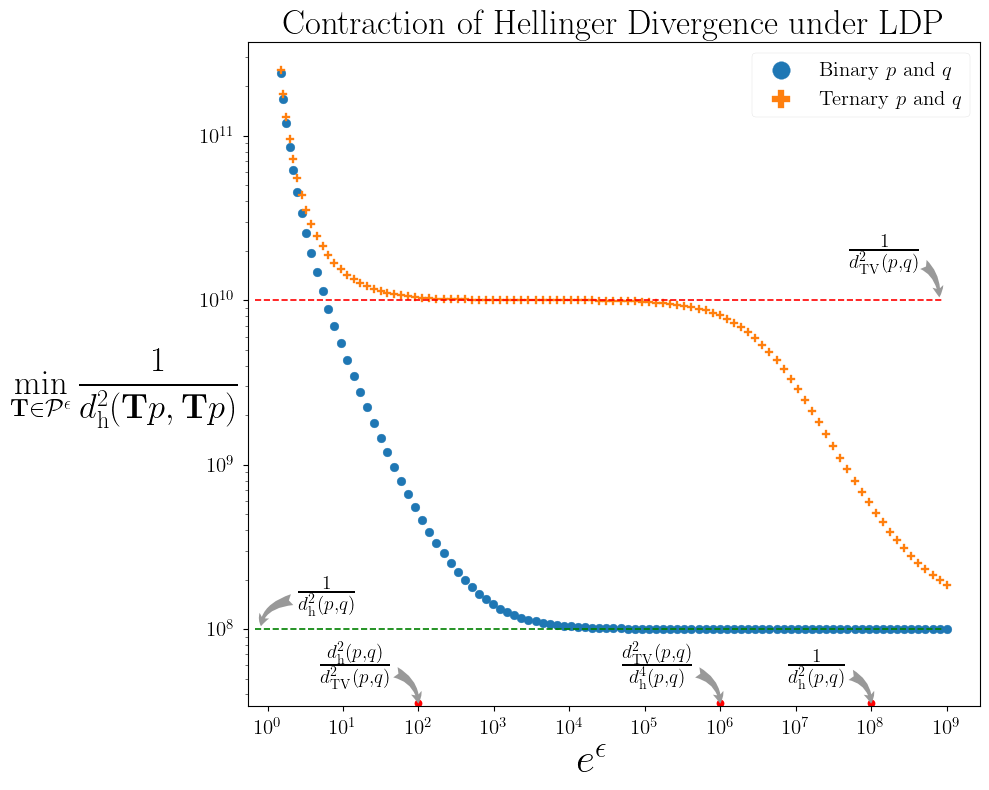

In [21]:
# Setting up the figure
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'axes.unicode_minus': False,
})
fig, ax = plt.subplots(1,1,figsize=(13,10))
fig.set_size_inches(w=10, h=8)
plt.style.use('seaborn-v0_8-paper')
plt.style.context('seaborn-v0_8-paper')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
el = Ellipse((2, -1), 0.5, 0.5)
ax.add_patch(el)


# Plot the data for binary and ternary
plt.scatter(eps_all, bin_sc, label = 'Binary $p$ and $q$', s=40, marker = 'o')
plt.scatter(eps_all, worstcase_ter, label = 'Ternary $p$ and $q$', s = 40, marker = 'P')

# Set the scale to \log base 10 for both figures
plt.xscale('log')
plt.yscale('log')

# Set the x-axis and y-axis labels
plt.ylabel(ylabel = '$\displaystyle \min_{\mathbf{T} \in \mathcal{P}^\epsilon}\\frac{1}{d_{\mathrm{h}}^2(\mathbf{T} p, \mathbf{T} p)}$',
                fontsize=25, rotation = 0, labelpad=55, y=0.42)
plt.xlabel('$e^{\epsilon}$', fontsize=30, x = 0.47)


# Create the x ticks at 10^i
min_value = 1
max_value = max(eps_all)
power10 = [10**i for i in range(20)]
ax.set_xticks([x for x in power10 if x <= max_value ])

# Create the base line of 1/tv^2, which corresponds to sample complexity at eps=1
plt.axhline(y = 1/nu**2, color = 'r', linestyle = '--', xmin = 0.01, xmax= 0.95, lw=1.2)
# Add the label 1/tv^2
ax.annotate('$\\frac{1}{d_{\mathrm{TV}}^2(p,q)}$',
            xy= (8/rho,1/nu**2), xytext=(0.5/rho,1.8/nu**2), xycoords='data', fontsize = 20,  
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90")
                            )
# Create the base line of 1/hel, which corresponds to sample complexity at eps=infty

plt.axhline(y = 1/rho, color = 'g', linestyle = '--', xmin = 0.01, xmax= 0.95, lw=1.2)
# Add the label 1/hel
ax.annotate('$\\frac{1}{d_{\mathrm{h}}^2(p,q)}$',
            xy= (xmin*1.5,1/rho), xytext=(2.5,1.5/rho), xycoords='data', fontsize = 20,  
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90")
                            )

# Annotate various points of interest on the horizontal axis
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
plt.ylim(bottom = ymin/2)
ymin = ymin/2


# The text corresponding to these points will be plotted at (x,y_min), 
# so that they are close enough to the points on the horizontal axis visually 
# The red dot corresponding to these points will be added at (x,y_min) 

upwards_scale = 1.05

# Annotating 1/hel: adding the text and arrow
ax.annotate('$\\frac{1}{d_{\mathrm{h}}^2(p,q)}$', 
            xy= (1/rho,ymin), xytext= (0.08/rho, 1.6*ymin), xycoords='data', fontsize = 20,  
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90")
                            )
# Annotating 1/hel: adding red dot
ax.plot(1/rho, upwards_scale*ymin, 'ro')

# Annotating hel/TV^2: adding the text and arrow
ax.annotate('$\\frac{d_{\mathrm{h}}^2(p,q)}{d_{\mathrm{TV}}^2(p,q)}$', 
                xy= (rho/(nu)**2,ymin), xytext=((0.05*rho/(nu)**2), 1.6*ymin), xycoords='data', fontsize = 20,  
                arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90")
                )
# Annotating hel/TV^2: adding the red dot
ax.plot(rho/(nu)**2, upwards_scale*ymin, 'ro')

# Annotating TV^2/hel^2: adding  the text and arrow
ax.annotate('$\\frac{d_{\mathrm{TV}}^2(p,q)}{d_{\mathrm{h}}^4(p,q)}$', 
                xy= ((nu/rho)**2,ymin), xytext=(0.05*(nu/rho)**2, 1.6*ymin), xycoords='data', fontsize = 20,  
                arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="angle3,angleA=0,angleB=-90")
                )
# Annotating TV^2/hel^2: adding the red dot
ax.plot((nu/rho)**2, upwards_scale*ymin, 'ro')

# Adding the title and legend
plt.title('Contraction of Hellinger Divergence under LDP', fontdict={'fontsize':25})
plt.legend(loc='upper right', fontsize=15,markerscale=2 )
plt.tight_layout()

plt.savefig('my_figure.pdf')